In [1]:
#HW_10_SQL_Alchemy_wen_WASHSTL201809DATA3
#dependencies
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn
style.use('fivethirtyeight')


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
precip_data = session.query(Measurement).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a168a76d8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
#get dates...Calculate the date 1 year ago from the last data point in the database
most_current = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = most_current[0]
last_date
#convert last_date to a datetime object
last_dateobj = datetime.strptime(last_date, "%Y-%m-%d")
year_before = last_dateobj.replace(year = last_dateobj.year - 1)
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [12]:
# Perform a query to retrieve the date and precipitation scores
results = (session.query(Measurement.date, Measurement.prcp).
           filter(Measurement.date >= year_before).statement)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(results, engine, index_col = 'date')
prcp_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [13]:
# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

prcp_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


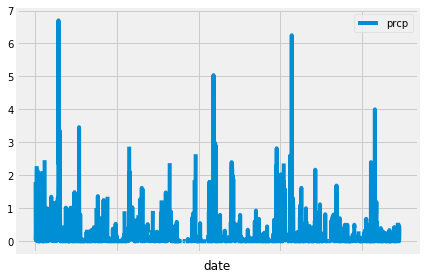

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(x_compat=True)

plt.tight_layout()
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(func.count(Station.station)).all()
num_station

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

(session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).
              filter(Measurement.station == 'USC00519281').all())


[(54.0, 85.0, 71.66378066378067)]

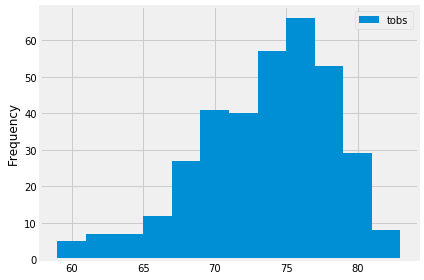

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram

HAS_results = (session.query(Measurement.tobs).
    filter(Measurement.station == 'USC00519281').
    filter(Measurement.date >= year_before).statement)

HAS_df = pd.read_sql_query(HAS_results, engine)
#HAS_df.head()

HAS_df.plot.hist(bins=12)
plt.tight_layout()
plt.show()


In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return (session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def prev_yr_calc_temps(start_date, end_date):
    
    start_dateobj = datetime.strptime(start_date, "%Y-%m-%d")
    end_dateobj = datetime.strptime(end_date, "%Y-%m-%d")
    
    prev_yr_start = start_dateobj.replace(year = start_dateobj.year - 1)
    prev_yr_end = end_dateobj.replace(year = end_dateobj.year - 1) 
    
    new_start = prev_yr_start.strftime("%Y-%m-%d")
    new_end = prev_yr_end.strftime("%Y-%m-%d")
    
    print(new_start,new_end)
      
    return (session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).
            filter(Measurement.date >= new_start).filter(Measurement.date <= new_end).all())

# function usage example
tmin, tavg, tmax = prev_yr_calc_temps('2012-02-28', '2012-03-05')[0]
               
print(tmin, tavg, tmax)               


2011-02-28 2011-03-05
61.0 69.75510204081633 75.0


/Users/william_nashs_mac/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


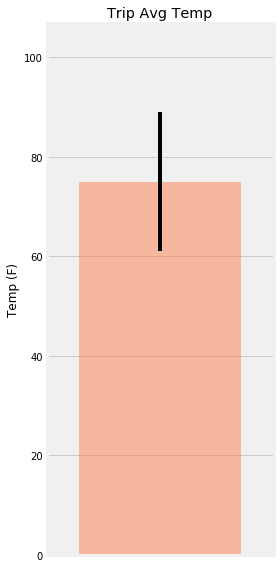

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.show()


In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#'2012-02-28', '2012-03-05'

start_date = '2012-02-28'
end_date = '2012-03-05'

start_dateobj = datetime.strptime(start_date, "%Y-%m-%d")
end_dateobj = datetime.strptime(end_date, "%Y-%m-%d")
    
prev_yr_start = start_dateobj.replace(year = start_dateobj.year - 1)
prev_yr_end = end_dateobj.replace(year = end_dateobj.year - 1) 
    
new_start = prev_yr_start.strftime("%Y-%m-%d")
new_end = prev_yr_end.strftime("%Y-%m-%d")
    
print(new_start,new_end)

station_info = [Station.station, Station.name, Station.latitude, 
               Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = (session.query(*station_info).
    filter(Measurement.station == Station.station).
    filter(Measurement.date >= new_start).
    filter(Measurement.date <= new_end).
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all())

print(results)


2011-02-28 2011-03-05
[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.33), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.23), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.19), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.96), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.45), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.63), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-08-16'
trip_end = '2018-08-23'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals


[(69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_df['date'] = trip_dates
trip_df.set_index(['date'],inplace=True)
trip_df.head()

,tmin,tavg,tmax
date,,,
2018-08-16,69.0,76.080000,83.0
2018-08-17,69.0,76.125000,83.0
2018-08-18,70.0,76.923077,84.0
2018-08-19,69.0,75.946429,85.0
2018-08-20,68.0,76.452830,82.0


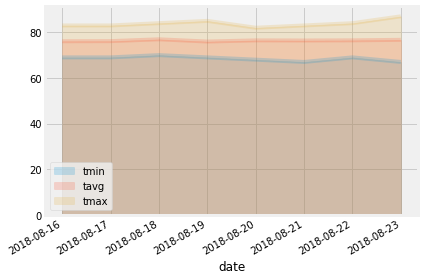

In [27]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
